<a href="https://colab.research.google.com/github/deeplylearned/cs6140/blob/main/Momentum_linearRegression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import time
from matplotlib import pyplot as plt
import random
import pandas as pd
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
df = pd.read_csv("/content/drive/MyDrive/boston.csv")
df.head()

,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,b,lstat,medv
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222,18.7,396.90,5.33,36.2


# Description of dataset
CRIM: Per capita crime rate by town <p>
ZN: Proportion of residential land zoned for lots over 25,000 sq. ft <p>
INDUS: Proportion of non-retail business acres per town <p>
CHAS: Charles River dummy variable (= 1 if tract bounds river; 0 otherwise) <p>
NOX: Nitric oxide concentration (parts per 10 million) <p>
RM: Average number of rooms per dwelling <p>
AGE: Proportion of owner-occupied units built prior to 1940 <p>
DIS: Weighted distances to five Boston employment centers <p>
RAD: Index of accessibility to radial highways <p>
TAX: Full-value property tax rate per $\$10,000$ <p>
PTRATIO: Pupil-teacher ratio by town <p>
B: $1000(Bk — 0.63)^2$, where Bk is the proportion of \[people of African American descent\] by town <p>
LSTAT: Percentage of lower status of the population <p>
MEDV: Median value of owner-occupied homes in $1000s <p>

MEDV is the feature we're trying to predict.

In [ ]:
df.describe()

,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,b,lstat,medv
count,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000
mean,3.613524,11.363636,11.136779,0.069170,0.554695,6.284634,68.574901,3.795043,9.549407,408.237154,18.455534,356.674032,12.653063,22.532806
std,8.601545,23.322453,6.860353,0.253994,0.115878,0.702617,28.148861,2.105710,8.707259,168.537116,2.164946,91.294864,7.141062,9.197104
min,0.006320,0.000000,0.460000,0.000000,0.385000,3.561000,2.900000,1.129600,1.000000,187.000000,12.600000,0.320000,1.730000,5.000000
25%,0.082045,0.000000,5.190000,0.000000,0.449000,5.885500,45.025000,2.100175,4.000000,279.000000,17.400000,375.377500,6.950000,17.025000
50%,0.256510,0.000000,9.690000,0.000000,0.538000,6.208500,77.500000,3.207450,5.000000,330.000000,19.050000,391.440000,11.360000,21.200000
75%,3.677082,12.500000,18.100000,0.000000,0.624000,6.623500,94.075000,5.188425,24.000000,666.000000,20.200000,396.225000,16.955000,25.000000
max,88.976200,100.000000,27.740000,1.000000,0.871000,8.780000,100.000000,12.126500,24.000000,711.000000,22.000000,396.900000,37.970000,50.000000


Entire dataset consists of numerical values.

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 506 entries, 0 to 505
Data columns (total 14 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   crim     506 non-null    float64
 1   zn       506 non-null    float64
 2   indus    506 non-null    float64
 3   chas     506 non-null    int64  
 4   nox      506 non-null    float64
 5   rm       506 non-null    float64
 6   age      506 non-null    float64
 7   dis      506 non-null    float64
 8   rad      506 non-null    int64  
 9   tax      506 non-null    int64  
 10  ptratio  506 non-null    float64
 11  b        506 non-null    float64
 12  lstat    506 non-null    float64
 13  medv     506 non-null    float64
dtypes: float64(11), int64(3)
memory usage: 55.5 KB


There are no null or missing values

In [ ]:
df.isnull().sum()

crim       0
zn         0
indus      0
chas       0
nox        0
rm         0
age        0
dis        0
rad        0
tax        0
ptratio    0
b          0
lstat      0
medv       0
dtype: int64

## Question 6 a
Defining the loss functions and overlaying the graphs

In [ ]:
def squared_loss(X):
     return np.power((X) , 2)
    
def absolute_loss(X):
    return np.abs(X)

def huber_loss(X, delta):
    return np.where(np.abs(X) <= delta, 0.5*np.power((X) , 2), (delta*np.abs(X)-0.5*(delta**2)) )

# Vanilla Gradient Descent

[[0.00000000e+00 1.80000000e-01 6.78152493e-02 ... 2.87234043e-01
  1.00000000e+00 8.96799117e-02]
 [2.35922539e-04 0.00000000e+00 2.42302053e-01 ... 5.53191489e-01
  1.00000000e+00 2.04470199e-01]
 [2.35697744e-04 0.00000000e+00 2.42302053e-01 ... 5.53191489e-01
  9.89737254e-01 6.34657837e-02]
 ...
 [6.11892474e-04 0.00000000e+00 4.20454545e-01 ... 8.93617021e-01
  1.00000000e+00 1.07891832e-01]
 [1.16072990e-03 0.00000000e+00 4.20454545e-01 ... 8.93617021e-01
  9.91300620e-01 1.31070640e-01]
 [4.61841693e-04 0.00000000e+00 4.20454545e-01 ... 8.93617021e-01
  1.00000000e+00 1.69701987e-01]]
(4277, array([ 8.4663808 , -0.89790391,  3.61760823, -0.60454713,  2.11592243,
       -0.0933129 ,  7.4552118 ,  2.12093786,  3.2658618 , -1.16058567,
       -1.07969539,  0.9022505 ,  8.99661621, -2.26443173]))


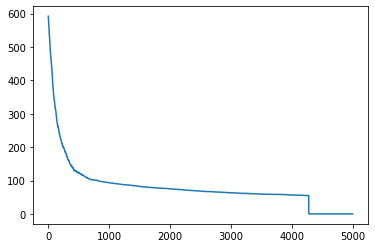

In [ ]:
def stochastic_gradient_quad(X,Y,alpha, iterations = 5000):
    m, n = X.shape
    theta_k = np.zeros((iterations,n+1))
    # theta_prev = np.ones(n+1)
    cost_k = np.zeros(iterations)
#     print(theta_k[0][0], theta_k[0][1])
#     print(np.ones(len(X)))
    
    # print(X)
    # print("pred", theta_k[0][1:].T.dot(X.T))
    # print("pred", theta_k[0][1:].T.dot(X[0]))
    for k in range(iterations-1):
      
      if k > 0 :
        # print(k)
        # print(np.sum( np.abs(cost_k[k] - cost_k[k-1])))
        if np.sum( np.abs(cost_k[k] - cost_k[k-1])) < 55:
          break

      j = random.randint(0,m-1)
      # print(theta_k[k][1:].shape)
      # print("x",X[j].shape)
      # print("pred", theta_k[k][1:].T.dot(X.T))
      predicted = theta_k[k][0]+ theta_k[k][1:].T.dot(X[j])
      # print(predicted )
      error = predicted- Y[j]

      # theta_prev = theta_k[k]
      theta_k[k+1][0] = theta_k[k][0] - alpha*error
      # print("iter",alpha*error)
      for i in range(1,n+1):
        # print(alpha*2*error*X[j][i])
        # print(i)
        # print(X[j])
        # print( theta_k[k])
      # theta_k[k+1][1] = theta_k[k][1] - alpha*error*X[j]
        theta_k[k+1][i] = theta_k[k][i] - alpha*error*X[j][i-1]
      # theta_k[k+1][1] = theta_k[k][1] - alpha*2*error*X[j]


      cost_k[k] = np.sum( np.power( ( theta_k[k][0] * np.ones(m)+ theta_k[k][1:].T.dot(X.T) - Y),2 ) ) /m
      # print(( theta_k[k][0] * np.ones(m)+ theta_k[k][1:].T.dot(X.T).shape - Y))
    # print(cost_k)
    plt.figure(0)
    plt.plot(cost_k[:len(cost_k)-1])
    # print(theta_k)
    # return(theta_k[iterations-1][0],theta_k[iterations-1][1])
    return k , theta_k[k]

features = [ name for name in df.columns if name != 'medv']
# print(features)

# Extracting the data points
X = df[features].values
# X = df[['lstat', 'rm']].values
# X = df['rm'].values
# print(X)

# Extracting the labels
Y = df['medv'].values

min_max_scaler = preprocessing.MinMaxScaler()
X_scaled = min_max_scaler.fit_transform(X)
print(X_scaled)
# print(Y)
# theta_0 , theta_1 = gradient_descent_quad(X,Y,0.01)
thetas = stochastic_gradient_quad(X_scaled,Y,0.001)
print(thetas)

Unnormalized input matrix giving overflow error.

# Stochastic Gradient descent with momentum

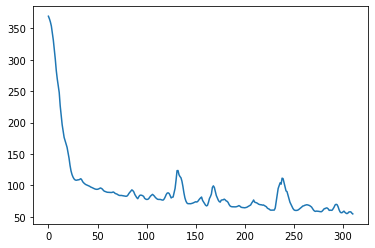

In [ ]:
def stochastic_gradient_momentum(X,Y,alpha,gamma=0.1, iterations = 3000):
    m, n = X.shape
    theta_k = np.ones((iterations,n+1))
    v1_k = np.zeros((iterations,n+1))
    # v2_k = np.zeros((iterations,n+1))
    cost_k = np.zeros(iterations)

    for k in range(iterations-1):

      if k > 0 : # Concvergence Criteria
        # print(np.sum( np.abs(cost_k[k] - cost_k[k-1])))
        if np.sum( np.abs(cost_k[k] - cost_k[k-1])) < 55:
          break

      j = random.randint(0,m-1)

      predicted = theta_k[k][0]+ theta_k[k][1:].T.dot(X[j])
      error = predicted- Y[j]
      # print(error)
      v1_k[k+1][0] = gamma * v1_k[k][0] + 2 * alpha * error  * theta_k[k][0]
      theta_k[k+1][0] = theta_k[k][0] - v1_k[k+1][0]

      for i in range(1,n+1):
        # print(gamma * v1_k[k][i] + 2 * alpha * error  * theta_k[k][i] * X[j][i-1])
        v1_k[k+1][i] = gamma * v1_k[k][i] + 2 * alpha * error  * theta_k[k][i] * X[j][i-1]
        theta_k[k+1][i] = theta_k[k][i] - v1_k[k+1][i]
        # theta_k[k+1][i] = theta_k[k][i] - alpha*2*error*X[j][i-1]
      # self.v_2 = self.beta * self.v_2 + 2 * self.b * self.w_2
      # self.w_2 -= self.lr * self.v_2


      # theta_k[k+1][0] = theta_k[k][0] - alpha*2*error
      # for i in range(1,n+1):
      #   theta_k[k+1][i] = theta_k[k][i] - alpha*2*error*X[j][i-1]

      cost_k[k] = np.sum( np.power( ( theta_k[k][0] * np.ones(m)+ theta_k[k][1:].T.dot(X.T) - Y),2 ) ) /m

    plt.figure(0)
    plt.plot(cost_k[:k])
    # print(v1_k)
    return k , theta_k[k]

features = [ name for name in df.columns if name != 'medv']
# print(features)

# Extracting the data points
X = df[features].values

# Extracting the labels
Y = df['medv'].values

min_max_scaler = preprocessing.MinMaxScaler()
X_scaled = min_max_scaler.fit_transform(X)
# print(X_scaled)
thetas = stochastic_gradient_momentum(X_scaled,Y,0.001,0.8)
# print(thetas)

# Nesterov Accelerated Gradient

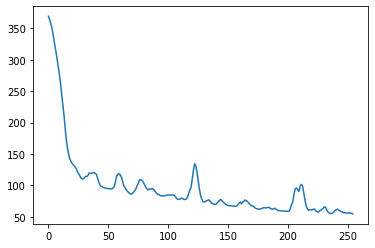

In [ ]:
def stochastic_gradient_nest(X,Y,alpha,gamma=0.1, iterations = 3000):
    m, n = X.shape
    theta_k = np.ones((iterations,n+1))
    v1_k = np.zeros((iterations,n+1))
    # v2_k = np.zeros((iterations,n+1))
    cost_k = np.zeros(iterations)
    theta_k_temp = np.zeros(n+1)

    for k in range(iterations-1):

      if k > 0 : # Convergence Criteria
        # print(np.sum( np.abs(cost_k[k] - cost_k[k-1])))
        if np.sum( np.abs(cost_k[k] - cost_k[k-1])) < 55:
          break

      j = random.randint(0,m-1)

      predicted = theta_k[k][0]+ theta_k[k][1:].T.dot(X[j])
      error = predicted- Y[j]
      
      theta_k_temp[0]  = theta_k[k][0]
      theta_k[k][0]  = theta_k[k][0] + v1_k[k][0]
      v1_k[k+1][0] = gamma * v1_k[k][0] - 2 * alpha * error  * theta_k[k][0]
      theta_k[k][0] = theta_k_temp[0]
      theta_k[k+1][0] = theta_k[k][0] + v1_k[k+1][0]

      for i in range(1,n+1):
        # v1_k[k+1][i] = gamma * v1_k[k][i] - 2 * alpha * error  * theta_k[k][i] * X[j][i-1]
        # theta_k[k+1][i] = theta_k[k][i] - v1_k[k+1][i]
        theta_k_temp[i]  = theta_k[k][i]
        theta_k[k][i]  = theta_k[k][i] + v1_k[k][i]
        v1_k[k+1][i] = gamma * v1_k[k][i] - 2 * alpha * error  * theta_k[k][i] * X[j][i-1]
        theta_k[k][i] = theta_k_temp[i]
        theta_k[k+1][i] = theta_k[k][i] + v1_k[k+1][i]

        # prev_w1 = self.w_1
        # self.w_1 = self.w_1 + self.beta * self.v_1
        # self.v_1 = self.beta * self.v_1 - self.lr * 2 * self.a * self.w_1
        # self.w_1 = prev_w1

        # prev_w2 = self.w_2
        # self.w_2 = self.w_2 + self.beta * self.v_2
        # self.v_2 = self.beta * self.v_2 - self.lr * 2 * self.b * self.w_2
        # self.w_2 = prev_w2

        # self.w_1 += self.v_1
        # self.w_2 += self.v_2

      cost_k[k] = np.sum( np.power( ( theta_k[k][0] * np.ones(m)+ theta_k[k][1:].T.dot(X.T) - Y),2 ) ) /m

    plt.figure(0)
    plt.plot(cost_k[:k])
    # print(v1_k)
    return k , theta_k[k]

features = [ name for name in df.columns if name != 'medv']
# print(features)

# Extracting the data points
X = df[features].values

# Extracting the labels
Y = df['medv'].values

min_max_scaler = preprocessing.MinMaxScaler()
X_scaled = min_max_scaler.fit_transform(X)
# print(X_scaled)
converge_point, thetas = stochastic_gradient_nest(X_scaled,Y,0.001,0.8)
# print(thetas)

Vanilla SGD: 3735.75
Vanilla MSE: 66.59918552058049
Vanilla time: 0.29776049852371217
Momentum: 433.05
Momentum MSE: 64.64329828506197
Momentum time: 0.053342461585998535
NAG: 447.7
NAG MSE: 65.02050605218143
Nesterov time: 0.06951428651809692


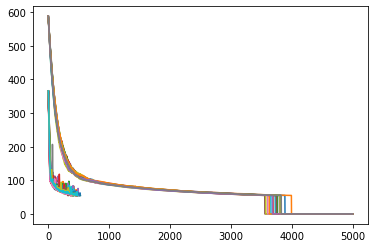

In [ ]:
vanilla = 0
momentum = 0
nesterov = 0

vanilla_error = 0
momentum_error = 0
nesterov_error = 0

vanilla_time = 0
momentum_time  = 0
nesterov_time  = 0

features = [ name for name in df.columns if name != 'medv']
# print(features)

# Extracting the data points
X = df[features].values

# Extracting the labels
Y = df['medv'].values

min_max_scaler = preprocessing.MinMaxScaler()
X_scaled = min_max_scaler.fit_transform(X)

for i in range(20):
  X_train, X_test, y_train, y_test = train_test_split(X_scaled, Y, test_size=0.2, random_state=1)
  m = len(X_test)
  # print(len(X_train))
  # print(len(y_train))
  vstart = time.time()
  converge_point1, thetas1 = stochastic_gradient_quad(X_train,y_train,0.001)
  vend = time.time()
  mstart = time.time()
  converge_point2, thetas2 = stochastic_gradient_momentum(X_train,y_train,0.001,0.6)
  mend = time.time()
  nstart = time.time()
  converge_point3, thetas3 = stochastic_gradient_nest(X_train,y_train,0.001,0.6)
  nend = time.time()

  vanilla +=  converge_point1
  momentum += converge_point2
  nesterov += converge_point3  

  vanilla_error += mean_squared_error(thetas1[0] * np.ones(m)+ thetas1[1:].T.dot(X_test.T),y_test)
  momentum_error +=  mean_squared_error(thetas2[0] * np.ones(m)+ thetas2[1:].T.dot(X_test.T),y_test)
  nesterov_error += mean_squared_error(thetas3[0] * np.ones(m)+ thetas3[1:].T.dot(X_test.T),y_test)

  vanilla_time += vend - vstart
  momentum_time +=   mend - mstart
  nesterov_time +=  nend - nstart


print("Vanilla SGD:", vanilla/20)
print("Vanilla MSE:", vanilla_error/20)
print("Vanilla time:", vanilla_time/20)
print("Momentum:", momentum/20 )
print("Momentum MSE:", momentum_error/20)
print("Momentum time:", momentum_time/20)
print("NAG:", nesterov/20)
print("NAG MSE:", nesterov_error/20)
print("Nesterov time:", nesterov_time/20)



Unfortunately, in the stochastic gradient case, Nesterov momentum does not improve the rate of convergence. It works more on stabilising the algorithm when the mometum is large for the same amount of learning rates.